# Predict Russian house price trend based on macroeconomic factors

### Table of Contents
* [Content](#Table-of-Contents)
* [1. Introduction](#1.-Introduction)
* [2. Data Analysis](#2.-Data-Analysis)
    * [2.1 Data cleaning and filling missing values](#2.1-Data-cleaning-and-filling-missing-values)
* [3. Linear Regression](#3.-Linear-Regression)
    * [3.1 By high correlation columns](#3.1-By-high-correlation-columns)
    * [3.2 Factors chosen by intuition](#3.2-Factors-chosen-by-intuition)
    * [3.3 Choose by XGBoost feature importance](#3.3-Choose-by-XGBoost-feature-importance)
    * [3.4 Feature Engineering](#3.4-Feature-Engineering)
* [4. Elastic Net](#4.-Elastic-Net) 
    * [4.1 Elastic Net with only the original features](#4.1-Elastic-Net-with-only-the-original-features)
    * [4.2 Elastic Net with engineering features](#4.2-Elastic-Net-with-engineering-features)
* [5. Gradient Boosting](#5.-Gradient-Boosting) 
    * [5.1 Gradient Boosting with only the original features](#5.1-Gradient-Boosting-with-only-the-original-features)
    * [5.2 Gradient Boosting with engineering features](#5.2-Gradient-Boosting-with-engineering-features)
* [6. Conclusion](#6.-Conclusion)

## 1. Introduction

To predict house price precisely, many kinds of information are needed from number of bedrooms to interest rate. This research finds the best accurate model based on macroeconomic factors such as GDP, exchange rate and so on. After that, the research will make macroeconomic index using the model (macro_economy.py).

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import pyplot
import xgboost as xgb
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import ElasticNet
from sklearn import model_selection, preprocessing
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from IPython.display import Image
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

/Users/PeterHwang/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# self-function definitions
def predictedVal(df): 
    pred = []
    for row in range(0,len(df)):
        estimate = 0.0
        for col in df[cols]:
            estimate = estimate + (multi_linear.params[col])*df.ix[row,col]
        estimate = estimate +(multi_linear.params['Intercept'])
        pred.append(estimate)
    return pred

def logToReal(array):
    temp = []
    for log_price in array:
        temp.append(np.exp(log_price))
    return temp

## 2. Data Analysis

To better understand the data, this part shows several graphs.

In [3]:
train_df = pd.read_csv("train.csv", parse_dates=["timestamp"], index_col=["timestamp"])
macro_df = pd.read_csv('macro.csv', parse_dates=['timestamp'], index_col=['timestamp'])

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64

The minimum price is:  100000
The maximum price is:  111111112


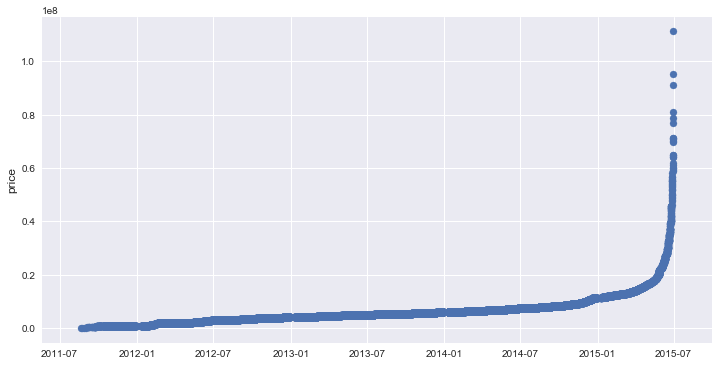

In [4]:
plt.figure(figsize=(12,6))
plt.scatter(train_df.index, np.sort(train_df.price_doc.values))
#plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
print train_df['price_doc'].describe()
print "\nThe minimum price is: ",train_df['price_doc'].min()
print "The maximum price is: ", train_df['price_doc'].max()
plt.show()

Skewness: 4.474745


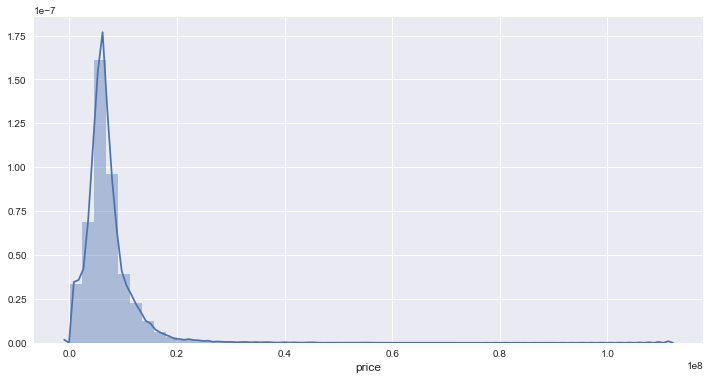

In [5]:
plt.figure(figsize=(12,6))
sns.distplot(train_df.price_doc.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
print("Skewness: %f" % train_df['price_doc'].skew())
plt.show()

House price has very long right tail. So take logarithm to normalise.

Skewness: -0.686716


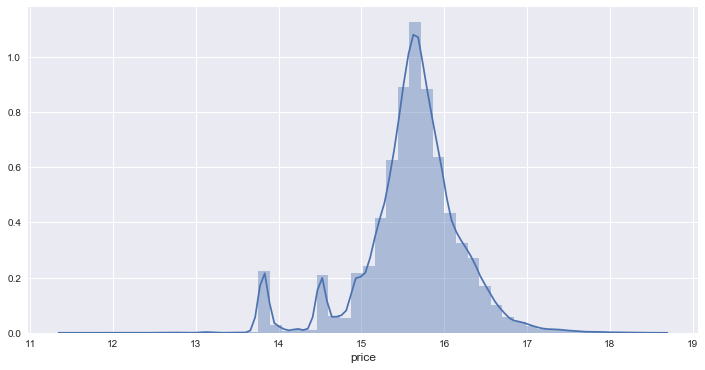

In [6]:
plt.figure(figsize=(12,6))
sns.distplot(np.log(train_df.price_doc.values), bins=50, kde=True)
plt.xlabel('price', fontsize=12)
print("Skewness: %f" % np.log(train_df['price_doc']).skew())
plt.show()

The graph looks normal distribution.

In [7]:
grouped_df = pd.DataFrame(train_df['price_doc'].resample('M').median())

In [8]:
grouped_df.columns = ['median_price']
#grouped_df['25%'] = train_df['price_doc'].resample('M', how=lambda x: np.percentile(x, q=25))
#grouped_df['75%'] = train_df['price_doc'].resample('M', how=lambda x: np.percentile(x, q=75))
grouped_df.head()

,median_price
timestamp,
2011-08-31,5850000
2011-09-30,5200000
2011-10-31,5500000
2011-11-30,5600000
2011-12-31,5450000


In [9]:
# Create and style traces
trace0 = go.Scatter(
    x = grouped_df.index,
    y = train_df['price_doc'].resample('M').median(),
    name = 'median',
    line = dict(
        color = ('rgb(205, 12, 24)'),
        width = 4)
)
trace1 = go.Scatter(
    x = grouped_df.index,
    y = train_df['price_doc'].resample('M', how=lambda x: np.percentile(x, q=25)),
    name = 'Q1(first quartile)',
    line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 4,
        dash = 'dot')
)
trace2 = go.Scatter(
    x = grouped_df.index,
    y = train_df['price_doc'].resample('M', how=lambda x: np.percentile(x, q=75)),
    name = 'Q3(third quartile)',
    #yaxis='y2',
    line = dict(
        color = ('#ff7f0e'),
        width = 4,
        dash = 'dot') # dash options include 'dash', 'dot', and 'dashdot'
)

data = [trace0, trace1, trace2]

# Edit the layout
layout = dict(title = 'House Price in Moscow')
    

fig = dict(data=data, layout=layout)
#py.iplot(fig, filename='styled-line')
Image(url="https://github.com/peterjhwang/Russian-house-price-trend-prediction/blob/master/House_Price_Trend_in_Moscow.jpg?raw=true")

Macroeconomic factors will affect entire house price trend other than individual house price. On the other hand, house specifications, for instance, number of bedrooms, location, distance between amenities, will affect individual house prices. 

The research assumes that median house prices are the good indicator of the trend. Therefore, it will find the best model predicting median house prices.

#### 2.1 Data cleaning and filling missing values

In [10]:
macro_df = macro_df.resample('M').mean()

In [11]:
df = pd.concat([grouped_df, macro_df], axis=1, join='inner')

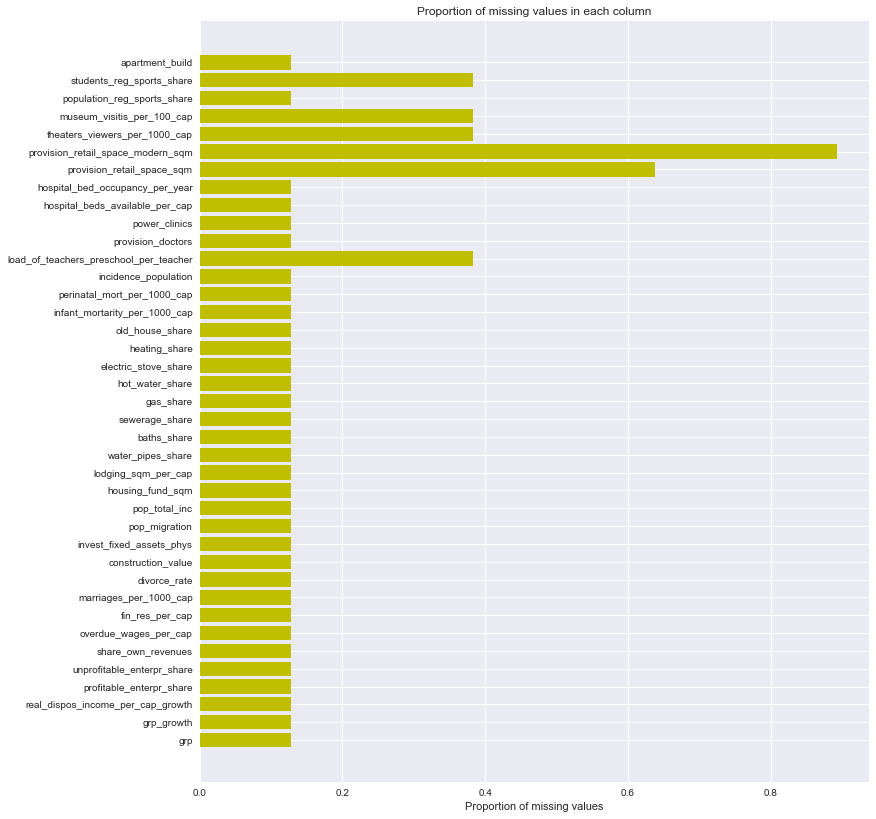

In [12]:
missing_df = (df.isnull().sum(axis=0)/df.shape[0]).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,14))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Proportion of missing values")
ax.set_title("Proportion of missing values in each column")
plt.show()

In [13]:
# remove a column has nan value more than 50%
del df['provision_retail_space_modern_sqm']
del df['provision_retail_space_sqm']

# fill all nan values with mean
for col in df.columns:
    df[col] = df[col].fillna(df[col].mean())

Skewness: 0.163461


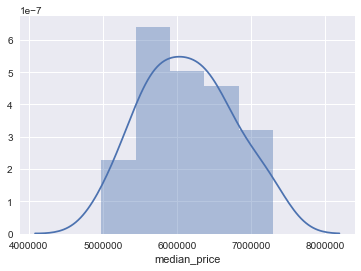

In [14]:
print("Skewness: %f" % df['median_price'].skew())
#print("Kurtosis: %f" % df['median_price'].kurt())
sns.distplot(df['median_price'])

Skewness: -0.025348


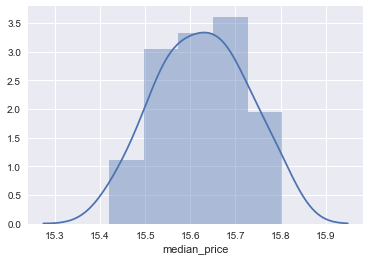

In [15]:
print("Skewness: %f" % np.log(df['median_price']).skew())
sns.distplot(np.log(df['median_price']))

In [16]:
df['log_price'] = np.log(df['median_price'])
del df['median_price']

### 3. Linear Regression

The research assumed that macroeconomic facotrs have strong relationship with house price trend. Therefore, firstly we try to find linear regression models.

#### 3.1 By high correlation columns
This section picked up high correlation columns, highest 5 columns and lowest 5 columns.

In [17]:
print df.corr()['log_price'].nlargest(6)
print '\n'
print df.corr()['log_price'].nsmallest()

log_price                              1.000000
bandwidth_sports                       0.854691
load_of_teachers_school_per_teacher    0.839201
fixed_basket                           0.818910
cpi                                    0.812997
salary                                 0.804282
Name: log_price, dtype: float64


gdp_annual_growth   -0.843232
provision_nurse     -0.826045
micex_rgbi_tr       -0.786246
rts                 -0.769177
load_on_doctors     -0.716483
Name: log_price, dtype: float64


In [18]:
cols = ['bandwidth_sports','load_of_teachers_school_per_teacher','fixed_basket', 
        'cpi', 'salary', 'rts', 'micex_rgbi_tr', 'provision_nurse', 'load_on_doctors', 'gdp_annual_growth']

In [19]:
multi_linear = smf.ols(formula='log_price ~ 1 + bandwidth_sports + load_of_teachers_school_per_teacher + fixed_basket + cpi + salary + rts + micex_rgbi_tr + provision_nurse + load_on_doctors + gdp_annual_growth',data=df).fit()
print multi_linear.params[0:10]
print 'R-Squared: ', multi_linear.rsquared
multi_linear.summary()

Intercept                              0.000932
bandwidth_sports                      -0.000010
load_of_teachers_school_per_teacher    0.004816
fixed_basket                           0.000026
cpi                                   -0.000932
salary                                 0.000094
rts                                    0.000218
micex_rgbi_tr                         -0.010422
provision_nurse                        0.117938
load_on_doctors                       -0.000410
dtype: float64
R-Squared:  0.841129247036


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     25.15
Date:                Fri, 04 Aug 2017   Prob (F-statistic):           6.23e-13
Time:                        09:40:32   Log-Likelihood:                 85.773
No. Observations:                  47   AIC:                            -153.5
Df Residuals:                      38   BIC:                            -136.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------
Intercept                               0.0009   7.72e-05     12.079      0.000         0.001     0.001
bandwidth_sports                    -1.029e-05   3.25e-06     -3.168      0.003     -1.69e-05 -3.71e-06
load_of_teachers_school_per_teacher     0.0048      0.000     15.250      0.000         0.004     0.005
fixed_basket                         2.622e-05   5.88e-05      0.446      0.658     -9.28e-05     0.000
cpi                                    -0.0009      0.002     -0.467      0.643        -0.005     0.003
salary                               9.383e-05   2.48e-05      3.777      0.001      4.35e-05     0.000
rts                                     0.0002   8.96e-05      2.435      0.020      3.68e-05     0.000
micex_rgbi_tr                          -0.0104      0.002     -4.557      0.000        -0.015    -0.006
provision_nurse                         0.1179      0.010     12.052      0.000         0.098     0.138
load_on_doctors                        -0.0004      0.000     -3.046      0.004        -0.001    -0.000
gdp_annual_growth                      -0.0003   2.42e-05    -12.022      0.000        -0.000    -0.000
==============================================================================
Omnibus:                        1.242   Durbin-Watson:                   0.918
Prob(Omnibus):                  0.537   Jarque-Bera (JB):                0.592
Skew:                          -0.239   Prob(JB):                        0.744
Kurtosis:                       3.271   Cond. No.                     1.34e+22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.34e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [20]:
predict1 = predictedVal(df)
predictVal1 = logToReal(predict1)

In [21]:
trace0 = go.Bar(x=grouped_df.index,y=grouped_df.median_price.values, name='actual')
trace1 = go.Bar(x=grouped_df.index, y=predictVal1, name='predicted')
data = [trace0, trace1]
layout = go.Layout(
    xaxis=dict(tickangle=-45),
    barmode='group',
    title = 'Linear Model using high correlation data'
)
fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='angled-text-bar')
Image(url="https://github.com/peterjhwang/Russian-house-price-trend-prediction/blob/master/Lm_high_cor_cols.jpg?raw=true")

In [22]:
sqrt_scores = [] #store sqrt_scores of all models in order to compare
model_name = []

In [23]:
print metrics.mean_absolute_error(df['log_price'], predict1)
print metrics.mean_squared_error(df['log_price'], predict1)
print np.sqrt(metrics.mean_squared_error(df['log_price'], predict1))
sqrt_scores.append(np.sqrt(metrics.mean_squared_error(df['log_price'], predict1)))
model_name.append('high correlation linear regression')

0.0291932731718
0.00152188784376
0.0390113809517


#### 3.2 Factors chosen by intuition

We create a model by collecting data that are expected to have strong correlations such as mortagage rate, exchange rate.

In [24]:
macro_columns = ['log_price','oil_urals', 'gdp_quart_growth', 'cpi', 'usdrub', 
                'salary_growth', 'unemployment', 'average_provision_of_build_contract_moscow', 'mortgage_rate', 
                 'deposits_rate','deposits_growth','rent_price_3room_eco',
                 'rent_price_3room_bus']

In [25]:
print df[macro_columns].corr()['log_price'].nlargest(10)
print df[macro_columns].corr()['log_price'].nsmallest()

log_price                                     1.000000
cpi                                           0.812997
usdrub                                        0.759078
rent_price_3room_bus                          0.669664
rent_price_3room_eco                          0.649769
deposits_rate                                 0.588184
mortgage_rate                                 0.521275
unemployment                                  0.442994
average_provision_of_build_contract_moscow    0.342944
deposits_growth                              -0.103362
Name: log_price, dtype: float64
oil_urals                                    -0.704347
gdp_quart_growth                             -0.609306
salary_growth                                -0.572325
deposits_growth                              -0.103362
average_provision_of_build_contract_moscow    0.342944
Name: log_price, dtype: float64


In [26]:
# choose significant features
cols=['oil_urals', 'gdp_quart_growth', 'cpi', 'usdrub','salary_growth', 'unemployment', 'mortgage_rate',
                'deposits_rate','rent_price_3room_bus', 'rent_price_3room_eco']

In [27]:
multi_linear = smf.ols(formula='log_price ~ 1 + oil_urals + gdp_quart_growth + cpi + usdrub +salary_growth + unemployment + mortgage_rate + deposits_rate + rent_price_3room_bus + rent_price_3room_eco',data=df).fit()
print multi_linear.params[0:11]
print 'R-Squared: ', multi_linear.rsquared
multi_linear.summary()

Intercept               16.104151
oil_urals               -0.002483
gdp_quart_growth         0.036072
cpi                      0.003107
usdrub                  -0.001217
salary_growth           -2.258010
unemployment            21.887836
mortgage_rate           -0.087255
deposits_rate           -0.018709
rent_price_3room_bus    -0.001148
rent_price_3room_eco    -0.005253
dtype: float64
R-Squared:  0.852990278926


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     20.89
Date:                Fri, 04 Aug 2017   Prob (F-statistic):           4.13e-12
Time:                        09:40:33   Log-Likelihood:                 87.597
No. Observations:                  47   AIC:                            -153.2
Df Residuals:                      36   BIC:                            -132.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept               16.1042      0.558     28.860      0.000        14.972    17.236
oil_urals               -0.0025      0.002     -1.560      0.127        -0.006     0.001
gdp_quart_growth         0.0361      0.013      2.846      0.007         0.010     0.062
cpi                      0.0031      0.001      2.583      0.014         0.001     0.006
usdrub                  -0.0012      0.005     -0.265      0.792        -0.011     0.008
salary_growth           -2.2580      0.650     -3.474      0.001        -3.576    -0.940
unemployment            21.8878      6.059      3.613      0.001         9.600    34.175
mortgage_rate           -0.0873      0.021     -4.188      0.000        -0.130    -0.045
deposits_rate           -0.0187      0.010     -1.897      0.066        -0.039     0.001
rent_price_3room_bus    -0.0011      0.001     -1.035      0.307        -0.003     0.001
rent_price_3room_eco    -0.0053      0.004     -1.247      0.221        -0.014     0.003
==============================================================================
Omnibus:                        0.764   Durbin-Watson:                   1.447
Prob(Omnibus):                  0.683   Jarque-Bera (JB):                0.758
Skew:                          -0.001   Prob(JB):                        0.685
Kurtosis:                       2.378   Cond. No.                     4.19e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
predict2 = predictedVal(df)
predictVal2 = logToReal(predict2)

In [29]:
trace0 = go.Bar(x=grouped_df.index,y=grouped_df.median_price.values, name='actual')
trace1 = go.Bar(x=grouped_df.index, y=predictVal2, name='predicted')
data = [trace0, trace1]
layout = go.Layout(
    xaxis=dict(tickangle=-45),
    barmode='group',
    title = 'Linear Model based on data selected by intuition'
)

fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='angled-text-bar')
Image(url="https://github.com/peterjhwang/Russian-house-price-trend-prediction/blob/master/Lm_intuition.jpg?raw=true")

In [30]:
print metrics.mean_absolute_error(df['log_price'], predict2)
print metrics.mean_squared_error(df['log_price'], predict2)
print np.sqrt(metrics.mean_squared_error(df['log_price'], predict2))
sqrt_scores.append(np.sqrt(metrics.mean_squared_error(df['log_price'], predict2)))
model_name.append('intuitively picked up linear regression')

0.0311223637412
0.00140826617388
0.0375268726898


#### 3.3 Choose by XGBoost feature importance

This part make a model based on the data which have high XGBoost feature importance value.

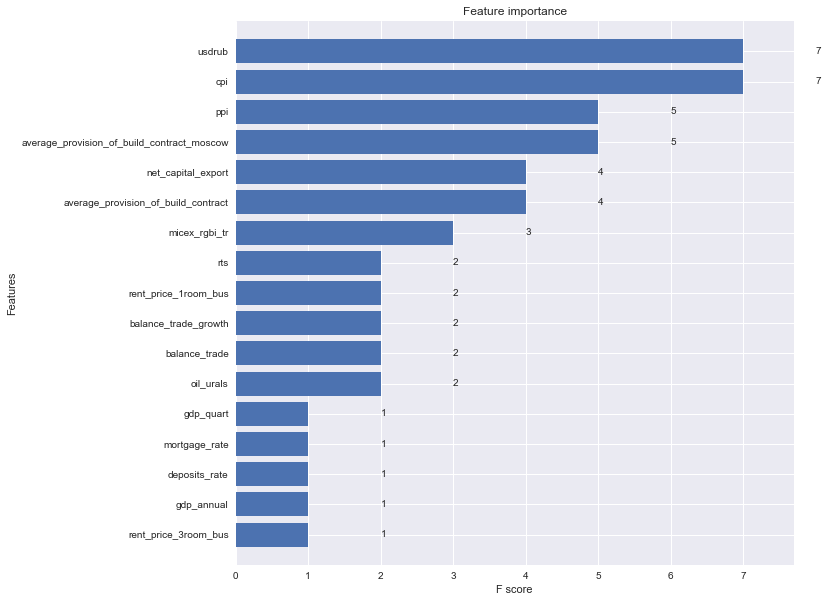

In [31]:
train_y = df.log_price.values
train_X = df.drop(["log_price"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

# plot the important features #
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model,height=0.8, ax=ax)
plt.show()

In [32]:
multi_linear = smf.ols(formula='log_price ~ 1 + cpi + net_capital_export + ppi + rts + average_provision_of_build_contract + usdrub + average_provision_of_build_contract_moscow + micex_cbi_tr',data=df).fit()
print multi_linear.params[0:11]
print 'R-Squared: ', multi_linear.rsquared
multi_linear.summary()

Intercept                                     14.412307
cpi                                           -0.001101
net_capital_export                             0.080529
ppi                                           -0.000321
rts                                           -0.000053
average_provision_of_build_contract           -0.005760
usdrub                                         0.004880
average_provision_of_build_contract_moscow     0.070810
micex_cbi_tr                                   0.005498
dtype: float64
R-Squared:  0.766015084203


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     15.55
Date:                Fri, 04 Aug 2017   Prob (F-statistic):           7.50e-10
Time:                        09:40:33   Log-Likelihood:                 76.675
No. Observations:                  47   AIC:                            -135.3
Df Residuals:                      38   BIC:                            -118.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------
Intercept                                     14.4123      0.705     20.434      0.000        12.984    15.840
cpi                                           -0.0011      0.002     -0.556      0.581        -0.005     0.003
net_capital_export                             0.0805      0.042      1.910      0.064        -0.005     0.166
ppi                                           -0.0003      0.001     -0.340      0.736        -0.002     0.002
rts                                        -5.277e-05      0.000     -0.501      0.620        -0.000     0.000
average_provision_of_build_contract           -0.0058      0.073     -0.079      0.937        -0.153     0.141
usdrub                                         0.0049      0.003      1.415      0.165        -0.002     0.012
average_provision_of_build_contract_moscow     0.0708      0.040      1.792      0.081        -0.009     0.151
micex_cbi_tr                                   0.0055      0.002      2.357      0.024         0.001     0.010
==============================================================================
Omnibus:                        0.754   Durbin-Watson:                   0.951
Prob(Omnibus):                  0.686   Jarque-Bera (JB):                0.832
Skew:                           0.265   Prob(JB):                        0.660
Kurtosis:                       2.621   Cond. No.                     1.38e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
cols = ['cpi' , 'net_capital_export' , 'ppi' , 'rts' , 'average_provision_of_build_contract' ,
        'usdrub' , 'average_provision_of_build_contract_moscow' , 'micex_cbi_tr']

In [34]:
predict3 = predictedVal(df)
predictVal3 = logToReal(predict3)

In [35]:
trace0 = go.Bar(x=grouped_df.index,y=grouped_df.median_price.values, name='actual')
trace1 = go.Bar(x=grouped_df.index, y=predictVal3, name='predicted')
data = [trace0, trace1]
layout = go.Layout(
    xaxis=dict(tickangle=-45),
    barmode='group',
    title = 'Linear Model using feature importance'
)

fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='angled-text-bar')
Image(url="https://github.com/peterjhwang/Russian-house-price-trend-prediction/blob/master/LM_feature_imp.jpg?raw=true")

In [36]:
print metrics.mean_absolute_error(df['log_price'], predict3)
print metrics.mean_squared_error(df['log_price'], predict3)
print np.sqrt(metrics.mean_squared_error(df['log_price'], predict3))
sqrt_scores.append(np.sqrt(metrics.mean_squared_error(df['log_price'], predict3)))
model_name.append('linear regression choosen by XGBoost feature importance')

0.0372823925019
0.00224143709481
0.0473438179154


#### 3.4 Feature Engineering

This part tries to use engineering features in order to create a linear model. The features are made of the multification between 7 high correlation factors and all the other factors.

In [37]:
print df.columns.get_loc("log_price")

94


In [38]:
corr_feature=np.where(np.array(abs(df.corr()['log_price']))>.80)[0]

In [39]:
for i in corr_feature[:-1]:
    print df.columns[i]

cpi
gdp_annual_growth
salary
fixed_basket
load_of_teachers_school_per_teacher
provision_nurse
bandwidth_sports


In [40]:
range_=np.delete(range(0,df.shape[1]),94)

In [41]:
feature_df = pd.DataFrame.copy(df)

In [42]:
for i in corr_feature[:-1]:
    for j in range_:
        feature_df[str('feature'+str(i)+'x'+str(j))]=feature_df.ix[:,i]*feature_df.ix[:,j]

In [43]:
feature_df.shape

(47, 753)

In [44]:
high_corr=np.where(np.array(abs(feature_df.corr()['log_price']))>.855)[0]

In [45]:
for i in high_corr[1:]:
    print feature_df.columns[i],

feature13x18 feature30x15 feature77x89 feature89x15 feature89x36 feature89x38 feature89x54 feature89x60 feature89x77 feature89x87 feature89x89 feature89x93


In [46]:
multi_linear = smf.ols(formula='log_price ~ feature13x18 + feature30x15 + feature77x89 +  feature89x15 + feature89x36 + feature89x38 + feature89x54 + feature89x60 + feature89x77 + feature89x87 + feature89x89 + feature89x93',data=feature_df).fit()
print multi_linear.params[0:13]
print 'R-Squared: ', multi_linear.rsquared
multi_linear.summary()

Intercept      -2.235828e-14
feature13x18   -3.413438e-01
feature30x15    1.202825e-05
feature77x89   -2.887664e-08
feature89x15   -1.815736e-06
feature89x36   -5.737210e-09
feature89x38   -1.909746e-08
feature89x54    1.400654e-07
feature89x60    1.264707e-06
feature89x77   -3.555207e-08
feature89x87   -1.110817e-08
feature89x89   -8.543391e-11
feature89x93    6.845155e-10
dtype: float64
R-Squared:  0.900888131355


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     50.64
Date:                Fri, 04 Aug 2017   Prob (F-statistic):           1.30e-17
Time:                        09:40:34   Log-Likelihood:                 96.862
No. Observations:                  47   AIC:                            -177.7
Df Residuals:                      39   BIC:                            -162.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept    -2.236e-14    1.5e-14     -1.495      0.143     -5.26e-14  7.89e-15
feature13x18    -0.3413      0.084     -4.045      0.000        -0.512    -0.171
feature30x15  1.203e-05   5.55e-06      2.166      0.037      7.94e-07  2.33e-05
feature77x89 -2.888e-08   6.62e-09     -4.364      0.000     -4.23e-08 -1.55e-08
feature89x15 -1.816e-06    8.5e-07     -2.136      0.039     -3.53e-06 -9.67e-08
feature89x36 -5.737e-09   2.47e-09     -2.319      0.026     -1.07e-08 -7.33e-10
feature89x38  -1.91e-08    1.3e-08     -1.470      0.149     -4.54e-08  7.17e-09
feature89x54  1.401e-07   9.53e-08      1.469      0.150     -5.28e-08  3.33e-07
feature89x60  1.265e-06   8.57e-07      1.476      0.148     -4.69e-07     3e-06
feature89x77 -3.555e-08   5.27e-09     -6.752      0.000     -4.62e-08 -2.49e-08
feature89x87 -1.111e-08   7.53e-09     -1.474      0.148     -2.63e-08  4.13e-09
feature89x89 -8.543e-11   1.45e-11     -5.888      0.000     -1.15e-10 -5.61e-11
feature89x93  6.845e-10   1.47e-10      4.667      0.000      3.88e-10  9.81e-10
==============================================================================
Omnibus:                        4.258   Durbin-Watson:                   1.286
Prob(Omnibus):                  0.119   Jarque-Bera (JB):                3.325
Skew:                           0.636   Prob(JB):                        0.190
Kurtosis:                       3.284   Cond. No.                     6.71e+26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.53e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [47]:
cols = ['feature13x18','feature30x15','feature77x89','feature89x15','feature89x36',
        'feature89x38','feature89x54','feature89x60','feature89x77','feature89x87',
        'feature89x89','feature89x93']

In [48]:
predict4 = predictedVal(feature_df)
predictVal4 = logToReal(predict4)

In [49]:
trace0 = go.Bar(x=grouped_df.index,y=grouped_df.median_price.values, name='actual')
trace1 = go.Bar(x=grouped_df.index, y=predictVal4, name='predicted')
data = [trace0, trace1]
layout = go.Layout(
    xaxis=dict(tickangle=-45),
    barmode='group',
    title = 'Linear Model with feature engineering'
)

fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='angled-text-bar')
Image(url="https://github.com/peterjhwang/Russian-house-price-trend-prediction/blob/master/Lm_feature_eng.jpg?raw=true")

In [50]:
print metrics.mean_absolute_error(df['log_price'], predict4)
print metrics.mean_squared_error(df['log_price'], predict4)
print np.sqrt(metrics.mean_squared_error(df['log_price'], predict4))
sqrt_scores.append(np.sqrt(metrics.mean_squared_error(df['log_price'], predict4)))
model_name.append('linear regression using feature engineering')

0.0249509770108
0.000949433078459
0.0308128719606


### 4. Elastic Net

The elastic net is a regularized regression method that linearly combines the L1 and L2 penalties of the lasso and ridge methods (Wikipedia.com). This part tries to predict median house price using sklearn elastic net model with only original features and with engineering features.

#### 4.1 Elastic Net with only the original features

In [51]:
X = df.drop('log_price', axis=1)
y = df['log_price']

In [52]:
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(X, y)

In [53]:
predictE1 = ENSTest.fit(X, y).predict(X)

In [54]:
print metrics.mean_absolute_error(df['log_price'], predictE1)
print metrics.mean_squared_error(df['log_price'], predictE1)
print np.sqrt(metrics.mean_squared_error(df['log_price'], predictE1))
sqrt_scores.append(np.sqrt(metrics.mean_squared_error(df['log_price'], predictE1)))
model_name.append('Elastic Net model')

0.0372449945095
0.00242848422558
0.0492796532616


#### 4.2 Elastic Net with engineering features

In [55]:
X = feature_df.drop('log_price', axis=1)
y = feature_df['log_price']

In [56]:
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(X, y)

In [57]:
predictE2 = ENSTest.fit(X, y).predict(X)
predictEVal = logToReal(predictE2)

In [58]:
print metrics.mean_absolute_error(df['log_price'], predictE2)
print metrics.mean_squared_error(df['log_price'], predictE2)
print np.sqrt(metrics.mean_squared_error(df['log_price'], predictE2))
sqrt_scores.append(np.sqrt(metrics.mean_squared_error(df['log_price'], predictE2)))
model_name.append('Elastice Net model with feature engineering')

0.00635860254849
6.17982546585e-05
0.00786118659354


In [59]:
trace0 = go.Bar(x=grouped_df.index,y=grouped_df.median_price.values, name='actual')
trace1 = go.Bar(x=grouped_df.index, y=predictEVal, name='predicted')
data = [trace0, trace1]
layout = go.Layout(
    xaxis=dict(tickangle=-45),
    barmode='group',
    title = 'Elastic Net Model with feature engineering'
)

fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='angled-text-bar')
Image(url="https://github.com/peterjhwang/Russian-house-price-trend-prediction/blob/master/Elastic_feature_eng.jpg?raw=true")

Interestingly, the elastic net model based only on original macroeconomic data is much less accurate than based on all features with feature engineering, their mean squared errors are 0.0492796532616 and 0.00786118659354, respectively.

### 5. Gradient Boosting

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees (Wikipedia.com). 

#### 5.1 Gradient Boosting with only the original features

In [60]:
X = df.drop('log_price', axis=1)
y = df['log_price']

In [61]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(X, y)

In [62]:
predictGB = GBest.fit(X, y).predict(X)
predictGBVal = logToReal(predictGB)

In [63]:
print metrics.mean_absolute_error(df['log_price'], predictGB)
print metrics.mean_squared_error(df['log_price'], predictGB)
print np.sqrt(metrics.mean_squared_error(df['log_price'], predictGB))
sqrt_scores.append(np.sqrt(metrics.mean_squared_error(df['log_price'], predictGB)))
model_name.append('Gradient Boosting model using only original features')

0.00243154853475
3.26687700179e-05
0.00571566006844


In [64]:
trace0 = go.Bar(x=grouped_df.index,y=grouped_df.median_price.values, name='actual')
trace1 = go.Bar(x=grouped_df.index, y=predictGBVal, name='predicted')
data = [trace0, trace1]
layout = go.Layout(
    xaxis=dict(tickangle=-45),
    barmode='group',
    title = 'Gradient Boosting Model with original data'
)

fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='angled-text-bar')
Image(url="https://github.com/peterjhwang/Russian-house-price-trend-prediction/blob/master/Gradient_Boost_ori.jpg?raw=true")

#### 5.2 Gradient Boosting with engineering features

In [65]:
X = feature_df.drop('log_price', axis=1)
y = feature_df['log_price']

In [66]:
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=3, max_features='sqrt',
                                               min_samples_leaf=15, min_samples_split=10, loss='huber').fit(X, y)

In [67]:
predictGB2 = GBest.fit(X, y).predict(X)
predictGB2Val = logToReal(predictGB2)

In [68]:
print metrics.mean_absolute_error(df['log_price'], predictGB2)
print metrics.mean_squared_error(df['log_price'], predictGB2)
print np.sqrt(metrics.mean_squared_error(df['log_price'], predictGB2))
sqrt_scores.append(np.sqrt(metrics.mean_squared_error(df['log_price'], predictGB2)))
model_name.append('Gradient Boosting model with feature enginerring')

0.0022602601305
6.74060852092e-05
0.00821012090101


In [69]:
trace0 = go.Bar(x=grouped_df.index,y=grouped_df.median_price.values, name='actual')
trace1 = go.Bar(x=grouped_df.index, y=predictGB2Val, name='predicted')
data = [trace0, trace1]
layout = go.Layout(
    xaxis=dict(tickangle=-45),
    barmode='group',
    title = 'Gradient Boosting Model with feature engineering'
)

fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='angled-text-bar')
Image(url="https://github.com/peterjhwang/Russian-house-price-trend-prediction/blob/master/Gradient_Boost_feature.jpg?raw=true")

### 6. Conclusion

In [70]:
for i in range(0, len(sqrt_scores)):
    print model_name[i],"has",sqrt_scores[i], "score."

high correlation linear regression has 0.0390113809517 score.
intuitively picked up linear regression has 0.0375268726898 score.
linear regression choosen by XGBoost feature importance has 0.0473438179154 score.
linear regression using feature engineering has 0.0308128719606 score.
Elastic Net model has 0.0492796532616 score.
Elastice Net model with feature engineering has 0.00786118659354 score.
Gradient Boosting model using only original features has 0.00571566006844 score.
Gradient Boosting model with feature enginerring has 0.00821012090101 score.


In [71]:
print "The most accurate model is",
print model_name[np.where(sqrt_scores==np.min(sqrt_scores))[0]]

The most accurate model is Gradient Boosting model using only original features


The research have tried several models in different ways. Using engineering features seems slightly better to predict median house prices among linear regression models. The research has also found that using engineering features is much more accurate in the elastic net models. On the other hand, for the gradient boosting model, predicting only based on original features is significantly better.